Initializing Movie Recommendation System...

Loading data...
Loaded 100000 ratings
Loaded 1682 movies
Loaded 943 users

Creating user-item matrix...
User-item matrix shape: (943, 1682)

Computing similarity matrices...
User similarity matrix computed
Item similarity matrix computed

Splitting data for evaluation...
Training set: 80000 ratings
Test set: 20000 ratings

=== User 196 Statistics ===
Total ratings: 39
Average rating: 3.62
Favorite genres: ['Comedy', 'Drama', 'Romance', 'Adventure', 'War']


=== Recommendations for User 196 using Collaborative Filtering ===

User's Rating History (sample):
                                title  rating
4                  Stand by Me (1986)       5
5   Ace Ventura: Pet Detective (1994)       5
31        Fish Called Wanda, A (1988)       5
15                        Babe (1995)       5
14     American President, The (1995)       5

Top 5 Recommendations:
--------------------------------------------------------------------------------
 1. Mrs. Dal

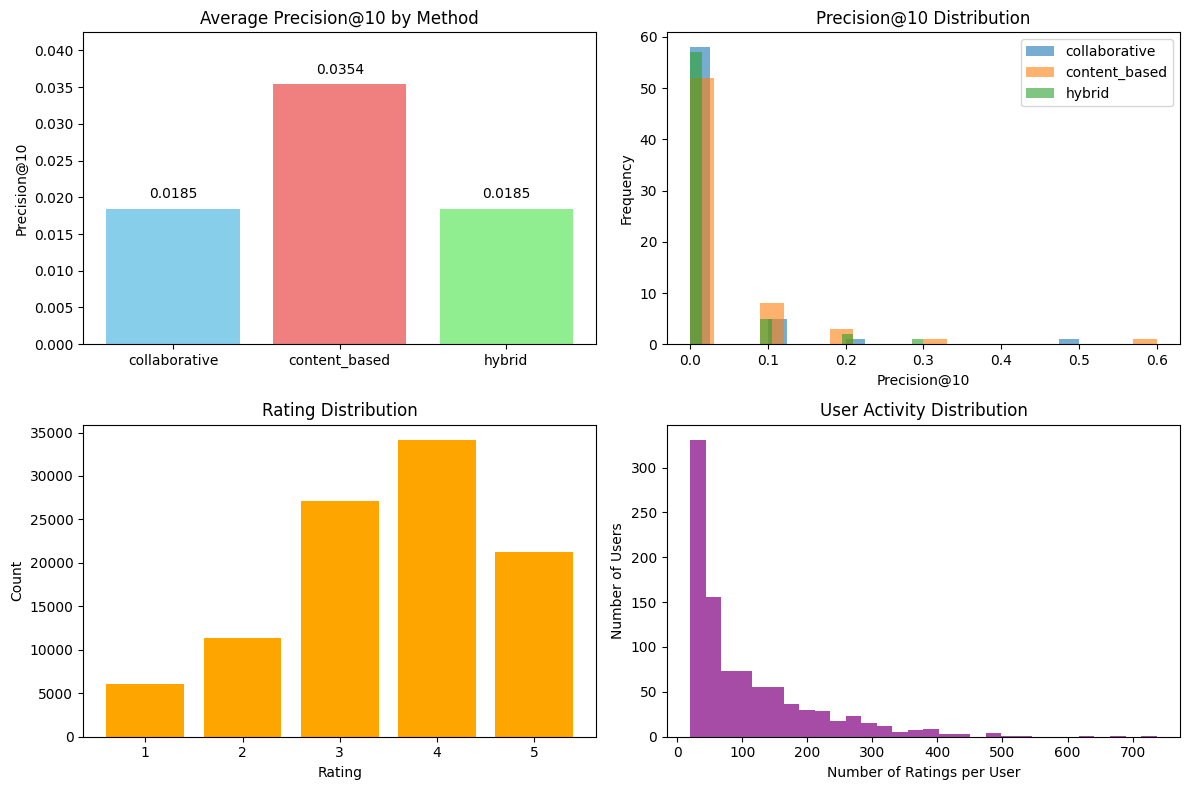


=== Summary ===
Collaborative Filtering - Precision@10: 0.0185
Content_Based Filtering - Precision@10: 0.0354
Hybrid Filtering - Precision@10: 0.0185
Model saved successfully to D:/Internship/task_5/model/

=== Dataset Analysis ===
Dataset sparsity: 0.9370 (93.70%)
Total users: 943
Total movies: 1682
Total ratings: 100000

Rating Statistics:
Min rating: 1
Max rating: 5
Mean rating: 3.53
Std rating: 1.13

Most Popular Movies:
  Star Wars (1977): 583 ratings, avg: 4.36
  Contact (1997): 509 ratings, avg: 3.8
  Fargo (1996): 508 ratings, avg: 4.16
  Return of the Jedi (1983): 507 ratings, avg: 4.01
  Liar Liar (1997): 485 ratings, avg: 3.16
  English Patient, The (1996): 481 ratings, avg: 3.66
  Scream (1996): 478 ratings, avg: 3.44
  Toy Story (1995): 452 ratings, avg: 3.88
  Air Force One (1997): 431 ratings, avg: 3.63
  Independence Day (ID4) (1996): 429 ratings, avg: 3.44

=== Most Similar Users to User 196 ===
Target user favorite genres: ['Comedy', 'Drama', 'Romance', 'Adventure', 

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

class MovieRecommendationSystem:
    def __init__(self, data_path):
        """
        Initialize the recommendation system with MovieLens 100K dataset
        
        Args:
            data_path (str): Path to the ml-100k directory
        """
        self.data_path = data_path
        self.ratings = None
        self.movies = None
        self.users = None
        self.user_item_matrix = None
        self.user_similarity_matrix = None
        self.item_similarity_matrix = None
        self.movie_features = None
        
    def load_data(self):
        """Load and preprocess the MovieLens 100K dataset"""
        
        # Load ratings data
        ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
        self.ratings = pd.read_csv(f'{self.data_path}/u.data', 
                                 sep='\t', names=ratings_cols)
        
        # Load movie information
        movie_cols = ['item_id', 'title', 'release_date', 'video_release_date', 
                     'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation',
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                     'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
        
        self.movies = pd.read_csv(f'{self.data_path}/u.item', 
                                sep='|', names=movie_cols, encoding='latin-1')
        
        # Load user information
        user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
        self.users = pd.read_csv(f'{self.data_path}/u.user', 
                               sep='|', names=user_cols)
        
        print(f"Loaded {len(self.ratings)} ratings")
        print(f"Loaded {len(self.movies)} movies") 
        print(f"Loaded {len(self.users)} users")
        
    def create_user_item_matrix(self):
        """Create user-item rating matrix"""
        self.user_item_matrix = self.ratings.pivot_table(
            index='user_id', 
            columns='item_id', 
            values='rating'
        ).fillna(0)
        
        print(f"User-item matrix shape: {self.user_item_matrix.shape}")
        
    def compute_user_similarity(self):
        """Compute user-user similarity using cosine similarity"""
        # Convert to sparse matrix for memory efficiency
        user_matrix_sparse = csr_matrix(self.user_item_matrix.values)
        
        # Compute cosine similarity
        self.user_similarity_matrix = cosine_similarity(user_matrix_sparse)
        
        # Convert to DataFrame for easier indexing
        self.user_similarity_matrix = pd.DataFrame(
            self.user_similarity_matrix,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )
        
        print("User similarity matrix computed")
        
    def compute_item_similarity(self):
        """Compute item-item similarity for content-based filtering"""
        # Create genre feature matrix
        genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                     'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                     'Thriller', 'War', 'Western']
        
        genre_matrix = self.movies[genre_cols].values
        
        # Compute item similarity based on genres
        item_similarity = cosine_similarity(genre_matrix)
        
        self.item_similarity_matrix = pd.DataFrame(
            item_similarity,
            index=self.movies['item_id'],
            columns=self.movies['item_id']
        )
        
        print("Item similarity matrix computed")
        
    def collaborative_filtering_recommendations(self, user_id, k=10, n_similar_users=50):
        """
        Generate recommendations using collaborative filtering
        
        Args:
            user_id (int): Target user ID
            k (int): Number of recommendations to return
            n_similar_users (int): Number of similar users to consider
            
        Returns:
            list: Top-K movie recommendations with scores
        """
        if user_id not in self.user_similarity_matrix.index:
            return []
            
        # Get similar users (excluding the user themselves)
        similar_users = self.user_similarity_matrix[user_id].sort_values(ascending=False)[1:n_similar_users+1]
        
        # Get movies the target user hasn't rated
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index
        
        # Calculate weighted ratings for unrated movies
        recommendations = {}
        
        for movie_id in unrated_movies:
            weighted_sum = 0
            similarity_sum = 0
            
            for similar_user_id, similarity_score in similar_users.items():
                if self.user_item_matrix.loc[similar_user_id, movie_id] > 0:
                    rating = self.user_item_matrix.loc[similar_user_id, movie_id]
                    weighted_sum += similarity_score * rating
                    similarity_sum += abs(similarity_score)
            
            if similarity_sum > 0:
                predicted_rating = weighted_sum / similarity_sum
                recommendations[movie_id] = predicted_rating
        
        # Sort and return top-K recommendations
        top_recommendations = sorted(recommendations.items(), 
                                   key=lambda x: x[1], reverse=True)[:k]
        
        return top_recommendations
    
    def content_based_recommendations(self, user_id, k=10):
        """
        Generate recommendations using content-based filtering
        
        Args:
            user_id (int): Target user ID
            k (int): Number of recommendations to return
            
        Returns:
            list: Top-K movie recommendations with scores
        """
        if user_id not in self.user_item_matrix.index:
            return []
            
        # Get user's rated movies and their ratings
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_movies = user_ratings[user_ratings > 0]
        
        if len(rated_movies) == 0:
            return []
        
        # Calculate user profile based on liked movies (rating >= 4)
        liked_movies = rated_movies[rated_movies >= 4]
        
        if len(liked_movies) == 0:
            liked_movies = rated_movies[rated_movies >= rated_movies.mean()]
        
        # Get unrated movies
        unrated_movies = user_ratings[user_ratings == 0].index
        
        # Calculate content-based scores
        recommendations = {}
        
        for movie_id in unrated_movies:
            if movie_id in self.item_similarity_matrix.index:
                # Calculate similarity to liked movies
                similarities = []
                weights = []
                
                for liked_movie_id in liked_movies.index:
                    if liked_movie_id in self.item_similarity_matrix.index:
                        sim = self.item_similarity_matrix.loc[movie_id, liked_movie_id]
                        similarities.append(sim)
                        weights.append(liked_movies[liked_movie_id])
                
                if similarities:
                    # Weighted average similarity
                    weighted_similarity = np.average(similarities, weights=weights)
                    recommendations[movie_id] = weighted_similarity
        
        # Sort and return top-K recommendations
        top_recommendations = sorted(recommendations.items(), 
                                   key=lambda x: x[1], reverse=True)[:k]
        
        return top_recommendations
    
    def hybrid_recommendations(self, user_id, k=10, cf_weight=0.7, cb_weight=0.3):
        """
        Generate hybrid recommendations combining collaborative and content-based filtering
        
        Args:
            user_id (int): Target user ID
            k (int): Number of recommendations to return
            cf_weight (float): Weight for collaborative filtering
            cb_weight (float): Weight for content-based filtering
            
        Returns:
            list: Top-K movie recommendations with combined scores
        """
        # Get recommendations from both methods
        cf_recs = dict(self.collaborative_filtering_recommendations(user_id, k=50))
        cb_recs = dict(self.content_based_recommendations(user_id, k=50))
        
        # Normalize scores to [0, 1] range
        if cf_recs:
            cf_max = max(cf_recs.values())
            cf_min = min(cf_recs.values())
            if cf_max != cf_min:
                cf_recs = {k: (v - cf_min) / (cf_max - cf_min) for k, v in cf_recs.items()}
        
        if cb_recs:
            cb_max = max(cb_recs.values())
            cb_min = min(cb_recs.values())
            if cb_max != cb_min:
                cb_recs = {k: (v - cb_min) / (cb_max - cb_min) for k, v in cb_recs.items()}
        
        # Combine scores
        all_movies = set(cf_recs.keys()) | set(cb_recs.keys())
        hybrid_scores = {}
        
        for movie_id in all_movies:
            cf_score = cf_recs.get(movie_id, 0)
            cb_score = cb_recs.get(movie_id, 0)
            hybrid_scores[movie_id] = cf_weight * cf_score + cb_weight * cb_score
        
        # Sort and return top-K recommendations
        top_recommendations = sorted(hybrid_scores.items(), 
                                   key=lambda x: x[1], reverse=True)[:k]
        
        return top_recommendations
    
    def get_movie_details(self, movie_ids):
        """Get movie details for given movie IDs"""
        if isinstance(movie_ids, (int, float)):
            movie_ids = [movie_ids]
            
        details = []
        for movie_id in movie_ids:
            movie_info = self.movies[self.movies['item_id'] == movie_id]
            if not movie_info.empty:
                details.append({
                    'item_id': movie_id,
                    'title': movie_info.iloc[0]['title'],
                    'genres': self._get_movie_genres(movie_id)
                })
        return details
    
    def _get_movie_genres(self, movie_id):
        """Get genres for a specific movie"""
        movie_info = self.movies[self.movies['item_id'] == movie_id]
        if movie_info.empty:
            return []
            
        genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                     'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                     'Thriller', 'War', 'Western']
        
        genres = []
        for genre in genre_cols:
            if movie_info.iloc[0][genre] == 1:
                genres.append(genre)
        return genres
    
    def split_data(self, test_ratio=0.2):
        """Split data into training and test sets"""
        # Sort by timestamp for temporal split
        sorted_ratings = self.ratings.sort_values('timestamp')
        
        # Split point
        split_point = int(len(sorted_ratings) * (1 - test_ratio))
        
        self.train_ratings = sorted_ratings.iloc[:split_point]
        self.test_ratings = sorted_ratings.iloc[split_point:]
        
        print(f"Training set: {len(self.train_ratings)} ratings")
        print(f"Test set: {len(self.test_ratings)} ratings")
        
        # Create training user-item matrix
        self.train_user_item_matrix = self.train_ratings.pivot_table(
            index='user_id', 
            columns='item_id', 
            values='rating'
        ).fillna(0)
        
    def evaluate_precision_at_k(self, k=10, threshold=4.0, method='collaborative'):
        """
        Evaluate precision at K for the recommendation system
        
        Args:
            k (int): Number of recommendations to evaluate
            threshold (float): Rating threshold for considering a movie as relevant
            method (str): 'collaborative', 'content_based', or 'hybrid'
            
        Returns:
            float: Average precision at K
        """
        # Temporarily store original matrices
        original_user_item = self.user_item_matrix.copy()
        original_user_sim = getattr(self, 'user_similarity_matrix', None)
        
        # Use training data for similarity computation
        self.user_item_matrix = self.train_user_item_matrix
        
        if method in ['collaborative', 'hybrid']:
            self.compute_user_similarity()
        if method in ['content_based', 'hybrid']:
            self.compute_item_similarity()
        
        precisions = []
        
        # Get unique users in test set
        test_users = self.test_ratings['user_id'].unique()
        
        for user_id in test_users[:100]:  # Evaluate on subset for efficiency
            if user_id not in self.train_user_item_matrix.index:
                continue
                
            # Get user's test ratings
            user_test = self.test_ratings[self.test_ratings['user_id'] == user_id]
            
            if len(user_test) == 0:
                continue
            
            # Get recommendations
            if method == 'collaborative':
                recs = self.collaborative_filtering_recommendations(user_id, k=k)
            elif method == 'content_based':
                recs = self.content_based_recommendations(user_id, k=k)
            else:  # hybrid
                recs = self.hybrid_recommendations(user_id, k=k)
            
            if not recs:
                continue
                
            # Get recommended movie IDs
            recommended_movies = [movie_id for movie_id, _ in recs]
            
            # Get actual relevant movies (rated >= threshold in test set)
            relevant_movies = user_test[user_test['rating'] >= threshold]['item_id'].tolist()
            
            if not relevant_movies:
                continue
            
            # Calculate precision at K
            recommended_relevant = [m for m in recommended_movies if m in relevant_movies]
            precision = len(recommended_relevant) / min(k, len(recommended_movies))
            precisions.append(precision)
        
        # Restore original matrices
        self.user_item_matrix = original_user_item
        if original_user_sim is not None:
            self.user_similarity_matrix = original_user_sim
        
        avg_precision = np.mean(precisions) if precisions else 0
        return avg_precision, precisions
    
    def display_recommendations(self, user_id, k=10, method='hybrid'):
        """
        Display recommendations for a user with movie details
        
        Args:
            user_id (int): Target user ID
            k (int): Number of recommendations
            method (str): Recommendation method
        """
        print(f"\n=== Recommendations for User {user_id} using {method.title()} Filtering ===")
        
        # Get user's rating history
        user_ratings = self.ratings[self.ratings['user_id'] == user_id]
        user_rated_movies = user_ratings.merge(self.movies, on='item_id')[['title', 'rating']]
        
        print(f"\nUser's Rating History (sample):")
        print(user_rated_movies.sort_values('rating', ascending=False).head())
        
        # Get recommendations
        if method == 'collaborative':
            recs = self.collaborative_filtering_recommendations(user_id, k=k)
        elif method == 'content_based':
            recs = self.content_based_recommendations(user_id, k=k)
        else:  # hybrid
            recs = self.hybrid_recommendations(user_id, k=k)
        
        if not recs:
            print("No recommendations available for this user.")
            return
        
        print(f"\nTop {k} Recommendations:")
        print("-" * 80)
        
        for i, (movie_id, score) in enumerate(recs, 1):
            movie_details = self.get_movie_details([movie_id])
            if movie_details:
                movie = movie_details[0]
                genres = ', '.join(movie['genres']) if movie['genres'] else 'Unknown'
                print(f"{i:2d}. {movie['title']}")
                print(f"    Score: {score:.3f} | Genres: {genres}")
                print()
    
    def analyze_performance(self):
        """Analyze and compare performance of different methods"""
        print("\n=== Performance Analysis ===")
        
        methods = ['collaborative', 'content_based', 'hybrid']
        results = {}
        
        for method in methods:
            print(f"\nEvaluating {method} filtering...")
            avg_precision, precisions = self.evaluate_precision_at_k(k=10, method=method)
            results[method] = {
                'avg_precision': avg_precision,
                'precisions': precisions
            }
            print(f"Average Precision@10: {avg_precision:.4f}")
        
        # Plot comparison
        plt.figure(figsize=(12, 8))
        
        # Precision comparison
        plt.subplot(2, 2, 1)
        methods_names = list(results.keys())
        avg_precisions = [results[method]['avg_precision'] for method in methods_names]
        
        bars = plt.bar(methods_names, avg_precisions, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Average Precision@10 by Method')
        plt.ylabel('Precision@10')
        plt.ylim(0, max(avg_precisions) * 1.2)
        
        # Add value labels on bars
        for bar, precision in zip(bars, avg_precisions):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{precision:.4f}', ha='center', va='bottom')
        
        # Precision distribution
        plt.subplot(2, 2, 2)
        for method in methods_names:
            if results[method]['precisions']:
                plt.hist(results[method]['precisions'], alpha=0.6, label=method, bins=20)
        plt.title('Precision@10 Distribution')
        plt.xlabel('Precision@10')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Dataset statistics
        plt.subplot(2, 2, 3)
        rating_counts = self.ratings['rating'].value_counts().sort_index()
        plt.bar(rating_counts.index, rating_counts.values, color='orange')
        plt.title('Rating Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        
        # User activity distribution
        plt.subplot(2, 2, 4)
        user_activity = self.ratings.groupby('user_id').size()
        plt.hist(user_activity, bins=30, color='purple', alpha=0.7)
        plt.title('User Activity Distribution')
        plt.xlabel('Number of Ratings per User')
        plt.ylabel('Number of Users')
        
        plt.tight_layout()
        plt.show()
        
        return results
    
    def get_user_statistics(self, user_id):
        """Get statistics for a specific user"""
        user_ratings = self.ratings[self.ratings['user_id'] == user_id]
        
        if len(user_ratings) == 0:
            return None
            
        stats = {
            'total_ratings': len(user_ratings),
            'avg_rating': user_ratings['rating'].mean(),
            'rating_std': user_ratings['rating'].std(),
            'favorite_genres': self._get_user_favorite_genres(user_id),
            'rating_distribution': user_ratings['rating'].value_counts().to_dict()
        }
        
        return stats
    
    def _get_user_favorite_genres(self, user_id):
        """Get user's favorite genres based on high ratings"""
        user_ratings = self.ratings[self.ratings['user_id'] == user_id]
        high_rated = user_ratings[user_ratings['rating'] >= 4]
        
        genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                     'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                     'Thriller', 'War', 'Western']
        
        genre_scores = {}
        
        for _, rating in high_rated.iterrows():
            movie_info = self.movies[self.movies['item_id'] == rating['item_id']]
            if not movie_info.empty:
                for genre in genre_cols:
                    if movie_info.iloc[0][genre] == 1:
                        genre_scores[genre] = genre_scores.get(genre, 0) + 1
        
        # Sort by frequency
        favorite_genres = sorted(genre_scores.items(), key=lambda x: x[1], reverse=True)
        return favorite_genres[:5]  # Top 5 genres
    
    def save_model(self, model_path='model'):
        """Save the trained model components"""
        os.makedirs(model_path, exist_ok=True)
        
        # Save all important components
        model_components = {
            'user_item_matrix': self.user_item_matrix,
            'user_similarity_matrix': self.user_similarity_matrix,
            'item_similarity_matrix': self.item_similarity_matrix,
            'movies': self.movies,
            'users': self.users,
            'ratings': self.ratings
        }
        
        # Save using joblib for better compression
        joblib.dump(model_components, f'{model_path}/recommendation_model.pkl')
        
        print(f"Model saved successfully to {model_path}/")
        
    def load_model(self, model_path='model'):
        """Load the trained model components"""
        try:
            model_components = joblib.load(f'{model_path}/recommendation_model.pkl')
            
            self.user_item_matrix = model_components['user_item_matrix']
            self.user_similarity_matrix = model_components['user_similarity_matrix']
            self.item_similarity_matrix = model_components['item_similarity_matrix']
            self.movies = model_components['movies']
            self.users = model_components['users']
            self.ratings = model_components['ratings']
            
            print("Model loaded successfully!")
            return True
            
        except FileNotFoundError:
            print(f"Model file not found at {model_path}/")
            return False

# Usage Example and Demonstration
def train_and_save_model():
    """Train the model and save it for use in Streamlit app"""
    
    # Initialize the system
    print("Initializing Movie Recommendation System...")
    recommender = MovieRecommendationSystem('D:/Internship/task_5/ml-100k')
    
    # Load data
    print("Loading data...")
    recommender.load_data()
    
    # Create matrices
    print("Creating user-item matrix...")
    recommender.create_user_item_matrix()
    
    print("Computing similarity matrices...")
    recommender.compute_user_similarity()
    recommender.compute_item_similarity()
    
    # Save the trained model
    print("Saving model...")
    recommender.save_model('D:/Internship/task_5/model')
    
    print("Model training and saving complete!")
    return recommender

def main():
    """Main function to demonstrate the recommendation system"""
    
    # Initialize the system
    print("Initializing Movie Recommendation System...")
    recommender = MovieRecommendationSystem('D:/Internship/task_5/ml-100k')
    
    # Load data
    print("\nLoading data...")
    recommender.load_data()
    
    # Create matrices
    print("\nCreating user-item matrix...")
    recommender.create_user_item_matrix()
    
    print("\nComputing similarity matrices...")
    recommender.compute_user_similarity()
    recommender.compute_item_similarity()
    
    # Split data for evaluation
    print("\nSplitting data for evaluation...")
    recommender.split_data(test_ratio=0.2)
    
    # Demo user
    demo_user_id = 196  # A user with many ratings
    
    # Show user statistics
    print(f"\n=== User {demo_user_id} Statistics ===")
    stats = recommender.get_user_statistics(demo_user_id)
    if stats:
        print(f"Total ratings: {stats['total_ratings']}")
        print(f"Average rating: {stats['avg_rating']:.2f}")
        print(f"Favorite genres: {[genre for genre, count in stats['favorite_genres']]}")
    
    # Generate recommendations using different methods
    print("\n" + "="*80)
    recommender.display_recommendations(demo_user_id, k=5, method='collaborative')
    
    print("\n" + "="*80)
    recommender.display_recommendations(demo_user_id, k=5, method='content_based')
    
    print("\n" + "="*80)
    recommender.display_recommendations(demo_user_id, k=5, method='hybrid')
    
    # Performance evaluation
    print("\n" + "="*80)
    results = recommender.analyze_performance()
    
    # Summary
    print("\n=== Summary ===")
    for method, result in results.items():
        print(f"{method.title()} Filtering - Precision@10: {result['avg_precision']:.4f}")
    
    # Save the model for Streamlit app
    recommender.save_model('D:/Internship/task_5/model')
    
    return recommender

# Additional utility functions for analysis
def analyze_dataset_characteristics(recommender):
    """Analyze dataset characteristics"""
    print("\n=== Dataset Analysis ===")
    
    # Sparsity analysis
    total_possible_ratings = len(recommender.users) * len(recommender.movies)
    actual_ratings = len(recommender.ratings)
    sparsity = 1 - (actual_ratings / total_possible_ratings)
    
    print(f"Dataset sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    print(f"Total users: {len(recommender.users)}")
    print(f"Total movies: {len(recommender.movies)}")
    print(f"Total ratings: {len(recommender.ratings)}")
    
    # Rating statistics
    print(f"\nRating Statistics:")
    print(f"Min rating: {recommender.ratings['rating'].min()}")
    print(f"Max rating: {recommender.ratings['rating'].max()}")
    print(f"Mean rating: {recommender.ratings['rating'].mean():.2f}")
    print(f"Std rating: {recommender.ratings['rating'].std():.2f}")
    
    # Most popular movies
    print(f"\nMost Popular Movies:")
    popular_movies = recommender.ratings.groupby('item_id').agg({
        'rating': ['count', 'mean']
    }).round(2)
    popular_movies.columns = ['rating_count', 'avg_rating']
    popular_movies = popular_movies.sort_values('rating_count', ascending=False).head(10)
    
    for movie_id in popular_movies.index:
        movie_title = recommender.movies[recommender.movies['item_id'] == movie_id]['title'].iloc[0]
        count = popular_movies.loc[movie_id, 'rating_count']
        avg_rating = popular_movies.loc[movie_id, 'avg_rating']
        print(f"  {movie_title}: {count} ratings, avg: {avg_rating}")

def compare_user_similarities(recommender, user_id, top_n=5):
    """Compare and display most similar users"""
    if user_id not in recommender.user_similarity_matrix.index:
        print(f"User {user_id} not found in similarity matrix")
        return
    
    similar_users = recommender.user_similarity_matrix[user_id].sort_values(ascending=False)[1:top_n+1]
    
    print(f"\n=== Most Similar Users to User {user_id} ===")
    target_user_stats = recommender.get_user_statistics(user_id)
    
    if target_user_stats:
        print(f"Target user favorite genres: {[g for g, c in target_user_stats['favorite_genres']]}")
    
    for similar_user_id, similarity_score in similar_users.items():
        similar_user_stats = recommender.get_user_statistics(similar_user_id)
        if similar_user_stats:
            print(f"\nUser {similar_user_id} (Similarity: {similarity_score:.3f})")
            print(f"  Favorite genres: {[g for g, c in similar_user_stats['favorite_genres']]}")
            print(f"  Total ratings: {similar_user_stats['total_ratings']}")
            print(f"  Avg rating: {similar_user_stats['avg_rating']:.2f}")

# Run the system
if __name__ == "__main__":
    # Execute main demonstration
    recommender = main()
    
    # Additional analysis
    analyze_dataset_characteristics(recommender)
    
    # Compare similar users
    compare_user_similarities(recommender, 196, top_n=3)
    
    print("\n" + "="*80)
    print("Movie Recommendation System Complete!")
    print("="*80)